In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import menpo.io as mio
from menpo.landmark import labeller, left_ventricle_34,left_ventricle_34_trimesh,left_ventricle_34_trimesh1
from menpofit.aam import HolisticAAM,PatchAAM
from menpo.transform import ThinPlateSplines
from menpo.feature import *
from menpofit.aam import LucasKanadeAAMFitter, WibergInverseCompositional
from menpofit.fitter import noisy_shape_from_bounding_box
from menpofit.visualize import plot_cumulative_error_distribution
from menpowidgets import *
from menpodetect import load_dlib_left_ventricle_detector
from menpo.io import export_pickle,import_pickle
from pathlib import Path
import sys
sys.path.insert(0,'I:/menpo/cvpr2015/alabortcvpr2015' )

# method to load a database
def load_database(path_to_images, crop_percentage,max_diagonal=400, max_images=None):
    images = []
    # load landmarked images
    for i in mio.import_images(path_to_images, max_images=max_images, verbose=True):
           
        # convert it to grayscale if needed
        if i.n_channels == 3:
            i = i.as_greyscale(mode='luminosity')
        # crop image
        i = i.crop_to_landmarks_proportion(crop_percentage)
        
        d = i.diagonal()
        if d > max_diagonal:
            i = i.rescale(float(max_diagonal) / d)
        # define a TriMesh which will be useful for Piecewise Affine Warp of HolisticAAM
        
        labeller(i, 'PTS', left_ventricle_34)#lv_34_trimesh
        labeller(i, 'PTS', left_ventricle_34_trimesh1)
        labeller(i, 'PTS', left_ventricle_34_trimesh)
        
        # append it to the list
        images.append(i)
    return images

In [3]:
path_to_lfpw = Path('K:/datasets/ptstwo-all/')
crop_percentage = 0.5
train_images = load_database(path_to_lfpw/ 'trainset',crop_percentage,max_images=None)
test_images = load_database(path_to_lfpw/ 'testset' , crop_percentage,max_images=4)
#visualize_images(training_images)

Found 212 assets, index the returned LazyList to import.
Found 4 assets, index the returned LazyList to import.


# Active Appearance Models

In [4]:
from alabortcvpr2015.aam import GlobalAAMBuilder

builder = GlobalAAMBuilder(features=fast_dsift, diagonal=None, 
                           scale_shapes=False, scales=(1, .5))
aam = builder.build(train_images, group='lv_34', verbose=True)

- Building modelsges size: 100%                                                 
  - Level 0: Warping images - 0%                                                

i:\develop\menpofit-master\menpofit\builder.py:338: MenpoFitModelBuilderWarning: The reference shape passed is not a TriMesh or subclass and therefore the reference frame (mask) will be calculated via a Delaunay triangulation. This may cause small triangles and thus suboptimal warps.
  MenpoFitModelBuilderWarning)


  - Level 0: Doneding appearance model                                          
  - Level 1: Doneding appearance model                                          
                                                              

In [5]:
from alabortcvpr2015.aam import GlobalAAMFitter, AIC, PIC
                  
fitter = GlobalAAMFitter(aam, algorithm_cls=AIC, n_shape=[3, 12], 
                         n_appearance=[25, 50], sampling_step=1)

In [6]:
np.random.seed(seed=1)

fitter_results = []

for j, i in enumerate(test_images[:]):
    
    gt_s = i.landmarks['lv_34']
    s = fitter.perturb_shape(gt_s, noise_std=0.0510)
    
    fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=20, prior=False)
    fr.downscale = 0.5
    
    fitter_results.append(fr)
    
    print 'Image: ', j
    print fr

Image:  0
Initial error: 0.0820
Final error: 0.0820
Image:  1
Initial error: 0.1115
Final error: 0.1115
Image:  2
Initial error: 0.1317
Final error: 0.1317
Image:  3
Initial error: 0.0969
Final error: 0.0969


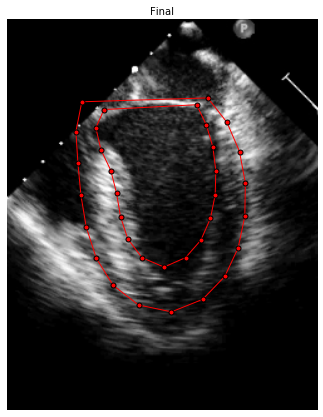

In [7]:
visualize_fitting_results(fitter_results)

## Local Warp

### Build

In [8]:
from menpo.feature import no_op, fast_dsift
from alabortcvpr2015.aam import PartsAAMBuilder

builder = PartsAAMBuilder(parts_shape=(15, 15), features=fast_dsift, diagonal=100, 
                          scale_shapes=False, scales=(1, .5))
aam = builder.build(train_images, group='lv_34', verbose=True)

- Building modelsges size: 100%                                                 
  - Level 0: Doneding appearance model                                          
  - Level 1: Doneding appearance model                                          
                                                              

### Test

In [9]:
sampling_mask = np.require(np.zeros(aam.parts_shape), dtype=np.bool)
sampling_mask[:] = True

#imshow(sampling_mask)

In [10]:
from alabortcvpr2015.aam import PartsAAMFitter, AIC, PIC
                  
fitter = PartsAAMFitter(aam, algorithm_cls=AIC, n_shape=[4, 12], 
                         n_appearance=[10,20],sampling_mask=sampling_mask)

In [11]:
np.random.seed(seed=1)

fitter_results = []

for j, i in enumerate(test_images[:]):
    
    gt_s = i.landmarks['lv_34']
    s = fitter.perturb_shape(gt_s, noise_std=0.04)
    
    fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=50, prior=True)
    fr.downscale = 0.5
    
    fitter_results.append(fr)
    
    print 'Image: ', j
    print fr

Image:  0
Initial error: 0.0757
Final error: 0.0757
Image:  1
Initial error: 0.0901
Final error: 0.0901
Image:  2
Initial error: 0.1069
Final error: 0.1069
Image:  3
Initial error: 0.0871
Final error: 0.0871


### Visualize Results

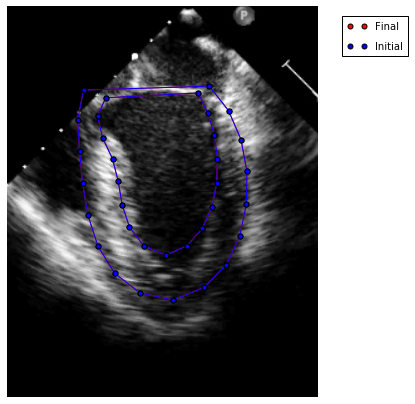

In [12]:
visualize_fitting_results(fitter_results)

### Save Results

In [18]:
from alabortcvpr2015.utils import pickle_dump

results = [fr.errors() for fr in fitter_results]

pickle_dump(results, '/data/PhD/Results/NONTAS_PIC_PARTSAAMs_AFW')

# Constrained Local Models

## SVM Experts

### Build

In [13]:
from menpo.feature import no_op, fast_dsift
from alabortcvpr2015.clm import CLMBuilder
from alabortcvpr2015.clm.classifier import LinearSVMLR 

offsets = np.meshgrid(range(-0, 1, 1), range(-0, 1, 1))
offsets = np.asarray([offsets[0].flatten(), offsets[1].flatten()]).T 

builder = CLMBuilder(parts_shape=(15, 15), features=fast_dsift, diagonal=100, 
                     classifier=LinearSVMLR, offsets=offsets, normalize_parts=True, 
                     covariance=1, scale_shapes=False, scales=(1, .5))

clm = builder.build(train_images, group='lv_34', verbose=True, 
                    threshold=0.015, dual=False, loss='squared_hinge', penalty='l1')

- Building modelsges size: 100%                                                 
  - Level 0: Warping images - 17%                                               

i:\develop\menpo-master\menpo\image\base.py:2788: MenpoDeprecationWarning: This method is no longer supported and will be removed in a future version of Menpo. Use .normalize_norm() instead (features package).
  MenpoDeprecationWarning)


  - Level 0: Doneding classifiers - 100%                                        
  - Level 1: Doneding classifiers - 100%                                        
                                                              

### Test

In [14]:
from alabortcvpr2015.clm import CLMFitter, RLMS
                  
fitter = CLMFitter(clm, n_shape=[3, 12], scale=100000, factor=100)

In [15]:
np.random.seed(seed=1)

fitter_results = []

for j, i in enumerate(test_images):
    
    gt_s = i.landmarks['lv_34']
    s = fitter.perturb_shape(gt_s, noise_std=0.14)
    
    fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=20, prior=True)
    
    fitter_results.append(fr)
    fr.downscale = 0.5
    
    print 'Image: ', j
    print fr

i:\develop\menpo-master\menpo\base.py:117: MenpoDeprecationWarning: the public API for inplace operations is deprecated and will be removed in a future version of Menpo. Use .from_vector() instead.
  'Use .from_vector() instead.', MenpoDeprecationWarning)


Image:  0
Initial error: 0.0757
Final error: 0.0622
Image:  1
Initial error: 0.0901
Final error: 0.0815
Image:  2
Initial error: 0.1069
Final error: 0.0995
Image:  3
Initial error: 0.0871
Final error: 0.0783


### Visualize Results

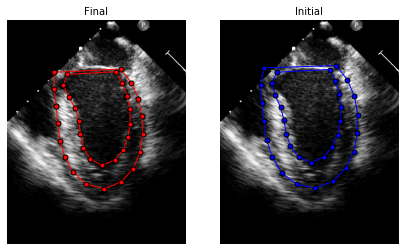

In [16]:
visualize_fitting_results(fitter_results)

### Timing

#### Total

In [ ]:
%timeit fitter.fit(i, s, gt_shape=gt_s, max_iters=20)

#### Per line

In [ ]:
import line_profiler
import IPython

ip = IPython.get_ipython()
ip.define_magic('lprun', line_profiler.magic_lprun)

In [ ]:
from alabortcvpr2015.clm import RLMS

%lprun -f RLMS.run fitter.fit(i, s, gt_shape=gt_s, max_iters=20)

## MCF Experts

### Build

In [17]:
from menpo.feature import no_op, fast_dsift, daisy
from alabortcvpr2015.clm import CLMBuilder
from alabortcvpr2015.clm.classifier import MCF

offsets = np.meshgrid(range(-0, 1, 1), range(-0, 1, 1))
offsets = np.asarray([offsets[0].flatten(), offsets[1].flatten()]).T 

builder = CLMBuilder(parts_shape=(15, 15), features=fast_dsift, diagonal=100, 
                     classifier=MCF, offsets=offsets, normalize_parts=False, 
                     covariance=2, scale_shapes=False, scales=(1, .5))

clm = builder.build(train_images, group='lv_34', verbose=True)

- Building modelsges size: 100%                                                 
  - Level 0: Doneding classifiers - 100%                                        
  - Level 1: Doneding classifiers - 100%                                        
                                                              

### Test

In [18]:
from alabortcvpr2015.clm import CLMFitter, RLMS
                  
fitter = CLMFitter(clm, n_shape=[3, 12], scale=100, factor=10)

In [22]:
np.random.seed(seed=1)

fitter_results = []

for j, i in enumerate(test_images):
    
    gt_s = i.landmarks['lv_34']
    s = fitter.perturb_shape(gt_s, noise_std=0.15)
    
    fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=50, prior=True)
    
    fitter_results.append(fr)
    fr.downscale = 0.5
    
    print 'Image: ', j
    print fr

Image:  0
Initial error: 0.1572
Final error: 0.1164
Image:  1
Initial error: 0.3154
Final error: 0.3419
Image:  2
Initial error: 0.3677
Final error: 0.3498
Image:  3
Initial error: 0.2400
Final error: 0.2226


### Visualize Results

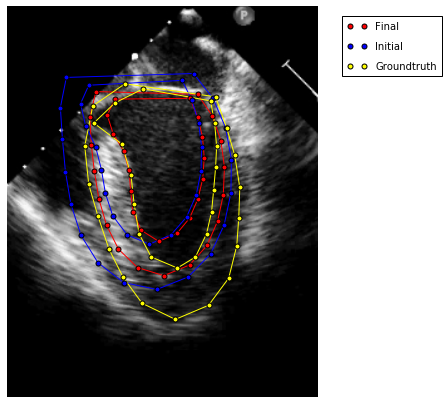

In [23]:
visualize_fitting_results(fitter_results)

# Unified

## Global

### Build

In [24]:
from menpo.feature import no_op, fast_dsift, daisy
from alabortcvpr2015.unified import GlobalUnifiedBuilder
from alabortcvpr2015.clm.classifier import MCF

offsets = np.meshgrid(range(-0, 1, 1), range(-0, 1, 1))
offsets = np.asarray([offsets[0].flatten(), offsets[1].flatten()]).T 

builder = GlobalUnifiedBuilder(parts_shape=(15, 15), features=fast_dsift, diagonal=100, 
                               classifier=MCF, offsets=offsets, normalize_parts=False, 
                               covariance=2, scale_shapes=False, scales=(1, .5))

unified = builder.build(train_images, group='lv_34', verbose=True)

- Building modelsges size: 100%                                                 
  - Level 0: Doneding classifiers - 100%                                        
  - Level 1: Doneding classifiers - 100%                                        
                                                              

### Test

In [25]:
from alabortcvpr2015.unified import GlobalUnifiedFitter 
                  
fitter = GlobalUnifiedFitter(unified, n_shape=[3, 12], n_appearance=[25, 50], 
                              sampling_step=8)#scale=1000,

i:\develop\menpo-master\menpo\shape\pointcloud.py:261: MenpoDeprecationWarning: The .lms property is deprecated. LandmarkGroups are now shapes themselves - so you can use them directly anywhere you previously used .lms.Simply remove ".lms" from your code and things will work as expected (and this warning will go away)
  MenpoDeprecationWarning)


In [29]:
np.random.seed(seed=1)

fitter_results = []

for j, i in enumerate(test_images):
    
    gt_s = i.landmarks['lv_34']
    s = fitter.perturb_shape(gt_s, noise_std=0.15)
    
    fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=40, prior=True)
    
    fitter_results.append(fr)
    fr.downscale = 0.5
    
    print 'Image: ', j
    print fr

Image:  0
Initial error: 0.0888
Final error: 0.0482
Image:  1
Initial error: 0.3610
Final error: 0.3067
Image:  2
Initial error: 0.3671
Final error: 0.3316
Image:  3
Initial error: 0.2380
Final error: 0.1706


### Visualize Results

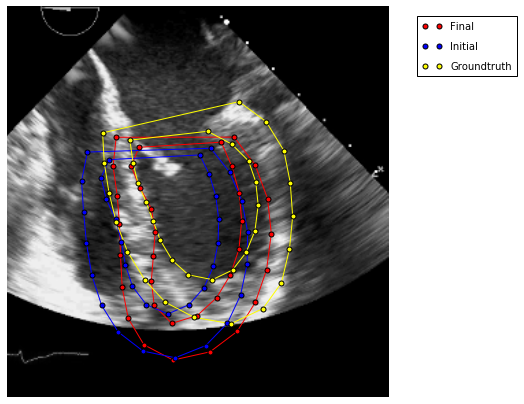

In [30]:
visualize_fitting_results(fitter_results)

## Parts

### Build

In [31]:
from menpo.feature import no_op, fast_dsift, daisy
from alabortcvpr2015.unified import PartsUnifiedBuilder
from alabortcvpr2015.clm.classifier import MCF

offsets = np.meshgrid(range(-0, 1, 1), range(-0, 1, 1))
offsets = np.asarray([offsets[0].flatten(), offsets[1].flatten()]).T 

builder = PartsUnifiedBuilder(parts_shape=(15, 15), features=fast_dsift, diagonal=100, 
                              classifier=MCF, offsets=offsets, normalize_parts=False, 
                              covariance=2, scale_shapes=False, scales=(1, .5))

unified = builder.build(train_images, group='lv_34', verbose=True)

- Building modelsges size: 100%                                                 
  - Level 0: Doneding classifiers - 100%                                        
  - Level 1: Doneding classifiers - 100%                                        
                                                              

### Test

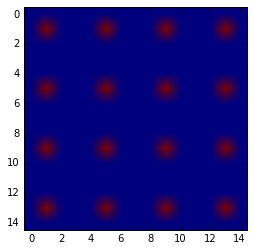

In [32]:
sampling_mask = np.require(np.zeros((15, 15)), dtype=np.bool)
sampling_mask[1::4, 1::4] = True
#sampling_mask[:] = True

imshow(sampling_mask)

In [35]:
from alabortcvpr2015.unified import PartsUnifiedFitter 
                  
fitter = PartsUnifiedFitter(unified, n_shape=[3, 12], n_appearance=[25, 50], 
                             sampling_mask=sampling_mask)

In [36]:
fitter._algorithms[0]._sigma2=10000
fitter._algorithms[1]._sigma2=10000
fitter._algorithms[0]._rho2=0
fitter._algorithms[1]._rho2=0

In [38]:
np.random.seed(seed=1)

fitter_results = []

for j, i in enumerate(test_images):
    
    gt_s = i.landmarks['lv_34'].lms
    s = fitter.perturb_shape(gt_s, noise_std=0.05)
    
    fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=20, prior=False)
    
    fitter_results.append(fr)
    fr.downscale = 0.5
    
    print 'Image: ', j
    print fr

Image:  0
Initial error: 0.0642
Final error: 0.0454
Image:  1
Initial error: 0.1222
Final error: 0.0944
Image:  2
Initial error: 0.1290
Final error: 0.0844
Image:  3
Initial error: 0.0970
Final error: 0.0628


### Visualize Results

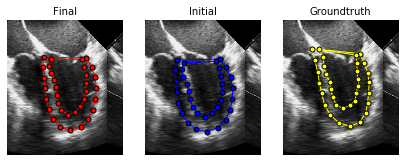

In [39]:
visualize_fitting_results(fitter_results)